In [55]:
import torch
import glob
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from model import *
from utils import *
from TrajectoryDataset import TrajectoryDataset
from torch_geometric.data import DataLoader

In [56]:
device = torch.device("cuda")

In [57]:
#Text file with graph connectivity with shape [2, num_edges]
graph_info='../EEG_data/edge_index3.txt'

In [58]:
edge_index = np.loadtxt(graph_info)
#Type must be torch.long
edge_index = torch.tensor(edge_index).long()

In [59]:
#Architecture of the model
num_features = 64 #Number of fetures assigned to each node
hidden_size = 128 #Dimension the graph latent space
hops=5 #Number of message passing steps

In [60]:
model = Pipeline(hops, num_features, hidden_size, num_features)
model = model.double().to(device)

## Preprocessing (Classifier learning)

In [ ]:
#Path to datasets to train classifier on
#Each dataset is list of torch_geometric.data.Data objects
#Each Data object has features x with shape [61, 200] and label y with shape [1] 
#x - EEG signal chunks for each node, y - label in [Control, AVH, nonAVH]
ptrain_dataset = '../EEG_data/data/train_data.pt'
pval_dataset = '../EEG_data/data/val_data.pt'

In [6]:
train_dataset = torch.load(ptrain_dataset)
val_dataset = torch.load(pval_dataset)
random.shuffle(train_dataset)
random.shuffle(val_dataset)

In [7]:
#Insert connectivity into each Data object (for each graph)
for data in train_dataset:
    data.edge_index = edge_index
for data in val_dataset:
    data.edge_index = edge_index

In [ ]:
batch_size = 32

In [8]:
#torch_geometric.data.DataLoader objects to create implement batches of graphs
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Optimal values for LR and WD
lr=1e-4
weight_decay=1e-4

In [20]:
#Adam is found to be optimal for the classification task
optimizer = torch.optim.Adam(
        model.classifier.parameters()
        lr=lr,
        weight_decay=weight_decay)

In [11]:
#Cross entropy proved to work efficiently
criterion = torch.nn.CrossEntropyLoss()

In [12]:
epoch = 0

In [21]:
#cl_ functions are taken from utils.py file
#tracks loss value along with accuracy values for both training and validation datasets
while epoch < 250:
    loss = cl_train(model.classifier, optimizer, criterion, train_loader, epoch, device)
    with torch.no_grad():
        train_acc = cl_test(model.classifier, train_loader, device)
        val_acc = cl_test(model.classifier, val_loader, device)    
    if epoch%5==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {val_acc:.4f}')  
    epoch += 1

Epoch: 200, Loss: 303.7709, Train Acc: 0.9460, Test Acc: 0.9343
Epoch: 205, Loss: 303.1889, Train Acc: 0.9466, Test Acc: 0.9332
Epoch: 210, Loss: 302.3599, Train Acc: 0.9466, Test Acc: 0.9327
Epoch: 215, Loss: 305.0781, Train Acc: 0.9454, Test Acc: 0.9332
Epoch: 220, Loss: 304.4869, Train Acc: 0.9471, Test Acc: 0.9343
Epoch: 225, Loss: 302.3089, Train Acc: 0.9464, Test Acc: 0.9343
Epoch: 230, Loss: 302.5591, Train Acc: 0.9464, Test Acc: 0.9332
Epoch: 235, Loss: 304.3581, Train Acc: 0.9479, Test Acc: 0.9358
Epoch: 240, Loss: 302.6204, Train Acc: 0.9464, Test Acc: 0.9338
Epoch: 245, Loss: 302.1441, Train Acc: 0.9473, Test Acc: 0.9353


In [22]:
#Save learned classifier to use its encoder in future
torch.save(model.state_dict(), 'new_classifier.pt')

In [13]:
#Attempt to clean memory for future Euler model learning
#Doesn't really work with single CPU and single GPU
#Better to restart the kernel with cells up to "Preprocessing (Classifier learning)" and load saved model 
torch.cuda.empty_cache()
del train_dataset, val_dataset, train_loader, val_loader

## Dataset creating

In [61]:
#Path with masks to send to glob.glob
path_data='../EEG_data/data/*/*/*/*'

In [62]:
#Create list with sufficient number of experiments
#Each experiment contributes 2 pairs
experiments = list(glob.glob(path_data))
random.shuffle(experiments)
experiments = experiments[:500] #change 500 with any number you consider sufficient

In [10]:
#Dataset containing pairs with consequent chunks 
#Each Data object has features x [61, 200], global features u [1,3], edge connectivity [2, num_edges], batch [1,61]
#x - EEG signal chunks for each node
#u - history of events + ear (e.g. [0 (no signal before), 1 (signal during), 1 (right ear)])
#batch - basically just 61 zeros. Needed for correct work of graph convolutions
train_dataset = TrajectoryDataset(experiments, edge_index)

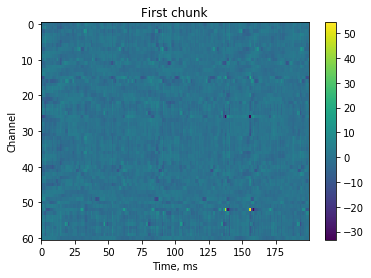

In [71]:
#First chunk we want to get
plt.imshow(train_dataset[0][0].x.cpu(), interpolation='nearest', aspect='auto')
plt.title('First chunk')
plt.xlabel('Time, ms')
plt.ylabel('Channel')
plt.colorbar()

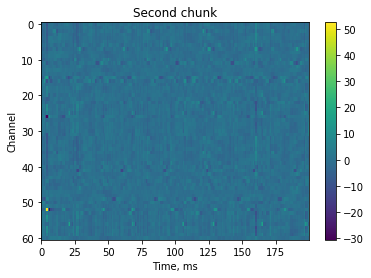

In [72]:
#Second chunk we want to roll back
plt.imshow(train_dataset[0][1].x.cpu(), interpolation='nearest', aspect='auto')
plt.title('Second chunk')
plt.xlabel('Time, ms')
plt.ylabel('Channel')
plt.colorbar()

## Euler Model Learning

In [ ]:
model.load_state_dict(torch.load('new_classifier.pt'))

In [11]:
val_dataset = train_dataset[int(0.2 * (len(train_dataset))):]
train_dataset = train_dataset[:int(0.8 * (len(train_dataset)))]

In [12]:
#Did not look for optimal values but those seem to work
lr=1e-4
weight_decay=1e-4

In [13]:
#Adam optimizer works fine
optimizer = torch.optim.Adam(
        list(model.processor.parameters()) + list(model.decoder.parameters()),
        lr=lr,
        weight_decay=weight_decay)

In [14]:
epoch = 0

In [ ]:
while epoch < 200:
    loss = 0
    MSE_train = 0
    for i in range(0,len(train_dataset),32): #I use pseudo batch 32 because it does not fit in memory otherwise
        loss += train(model, optimizer, train_dataset[i:(i+32)], device)
        with torch.no_grad():
            MSE_train += test(model, train_dataset[i:(i+32)], device)
    with torch.no_grad():
        MSE_val = test(model, val_dataset, device)

    if epoch % 1 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f} , MSE Train: {MSE_train:.4f}, MSE Val: {MSE_val:.4f}') #, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}')
    
    epoch += 1
    
    if epoch % 100 == 0:
        torch.save(model.state_dict(), 'nmodel_' + str(epoch)+'.pt')

## Visualization 

In [15]:
#Best model trained
model.load_state_dict(torch.load('./models/model_' + str(1400) + '.pt'))

<All keys matched successfully>

In [16]:
#Take random pair from validation dataset
pair = val_dataset[0]
current, next_ = pair
current = current.to(device)
next_ = next_.to(device)

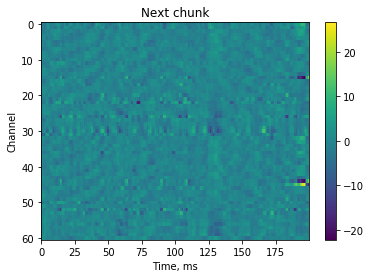

In [17]:
#Next chunk we want to roll back
plt.imshow(next_.x.detach().cpu(), interpolation='nearest', aspect='auto')
plt.title('Next chunk')
plt.xlabel('Time, ms')
plt.ylabel('Channel')
plt.colorbar()

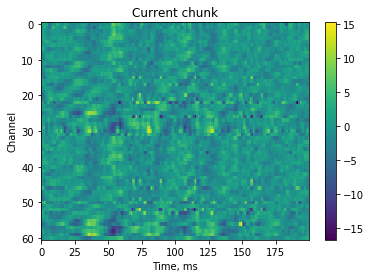

In [18]:
#Current chunk we want to get
plt.imshow(current.x.detach().cpu(), interpolation='nearest', aspect='auto')
plt.title('Current chunk')
plt.xlabel('Time, ms')
plt.ylabel('Channel')
plt.colorbar()

In [20]:
#Put chunks to encoded space
enc_current = model.encoder(current.x)
enc_next = model.encoder(next_.x)

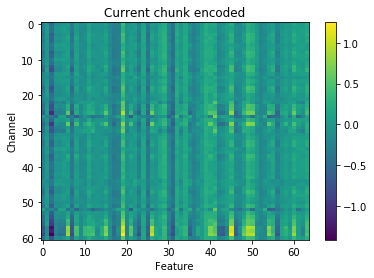

In [21]:
#Current chunk encoded
plt.imshow(enc_current.detach().cpu(), interpolation='nearest', aspect='auto')
plt.title('Current chunk encoded')
plt.xlabel('Feature')
plt.ylabel('Channel')
plt.colorbar()

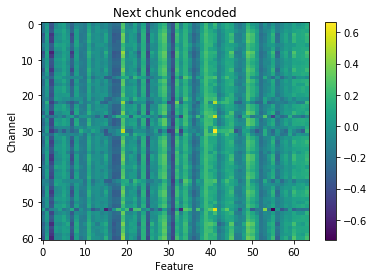

In [22]:
#Next chunk encoded
plt.imshow(enc_next.detach().cpu(), interpolation='nearest', aspect='auto')
plt.title('Next chunk encoded')
plt.xlabel('Feature')
plt.ylabel('Channel')
plt.colorbar()

In [23]:
#Get update (rather downgrade) to next chunk to get current chunk in the encoded space
update_x = model(
    next_.x, next_.edge_index, next_.u, next_.batch)

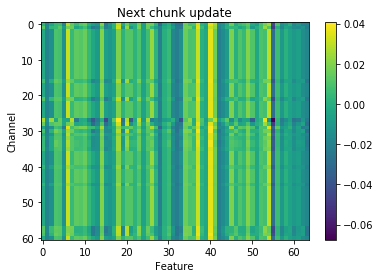

In [24]:
#Update of the next chunk
plt.imshow(update_x.detach().cpu(), interpolation='nearest', aspect='auto')
plt.title('Next chunk update')
plt.xlabel('Feature')
plt.ylabel('Channel')
plt.colorbar()

In [25]:
#Predicted state for current chunk
predicted_current = enc_next + update_x 

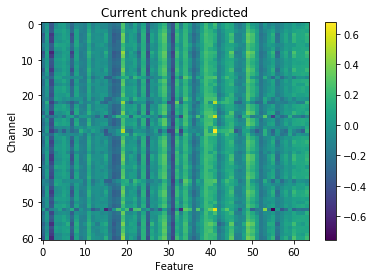

In [26]:
#Predicted state for current chunk
plt.imshow(predicted_current.detach().cpu(), interpolation='nearest', aspect='auto')
plt.title('Current chunk predicted')
plt.xlabel('Feature')
plt.ylabel('Channel')
plt.colorbar()

In [29]:
#Absolute difference between predicted and exact encoded state
difference = (predicted_current - enc_current).abs()

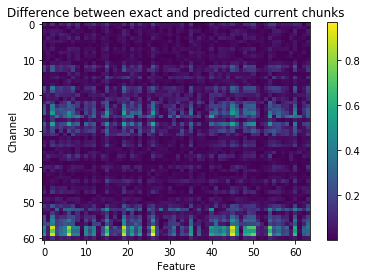

In [53]:
#Absolute difference between predicted and exact encoded state
plt.imshow(difference.detach().cpu(), interpolation='nearest', aspect='auto')
plt.title('Difference between exact and predicted current chunks')
plt.xlabel('Feature')
plt.ylabel('Channel')
plt.colorbar()